### Create dataset on some subsets of DRS data for haystack.deepset.ai
Per https://haystack.deepset.ai/tutorials/08_preprocessing, Haystack expects data to be provided as a list of documents in the following dictionary format. See also https://docs.haystack.deepset.ai/docs/document_store
need also to store the answer and the title

In [1]:
docs = [
    {
        'content': DOCUMENT_TEXT_HERE,                                                              
        'meta': {'name': DOCUMENT_NAME, ...}
    }, ...
]

SyntaxError: ':' expected after dictionary key (1725972168.py, line 4)

### Import DRS metadata

In [4]:
import pandas as pd
import numpy as np
import os
import glob

metadata_mapping = pd.read_excel(os.path.join(os.getcwd(),'data','DRS','index','FAA DRS','DRS Document Types Metadata Mapping.xlsx')) # from https://drs.faa.gov/help/helpdetails and https://drs.faa.gov/help/helpdetails

doc_types = pd.unique(metadata_mapping.loc[:, "Document Type Name in API request"])
doc_types = [val for val in doc_types if isinstance(val, str)]

common_fields = []
for n,doc_type in enumerate(doc_types):
    metadata_names = metadata_mapping.loc[metadata_mapping.loc[:, "Document Type Name in API request"]==doc_type, "Metadata Name in API Response "]

    if n>0:
        common_fields = list(set(metadata_names) & set(common_fields))
    else:
        common_fields = list(set(metadata_names))

Subset for which it was possible to split paragraphs

In [5]:
doc_types = ['AC',
            'ORDER_8300.10',
            'ORDER_8400.10',
            'ORDER_8700.1',
            'ORDER_8740.1',
            'ORDER_8900.1',
            'ORDERS']

In [6]:
df_drsmeta = None

for doc_type in doc_types:
    parquet_files = sorted(glob.glob(os.path.join(os.getcwd(),'data', 'DRS', 'index', doc_type+'_202*.parquet')), 
                        key=os.path.getctime, 
                        reverse=True)

    if len(parquet_files)>0:
        this_parquet = pd.read_parquet(parquet_files[0])
        this_parquet.insert(0, 
                            "doc_type", 
                            value=pd.Series(data=doc_type, index=this_parquet.index, dtype="string"))

        if df_drsmeta is None:
            df_drsmeta = this_parquet
        else:
            df_drsmeta = pd.concat([this_parquet,
                                    df_drsmeta])

### Import DRS or non-DRS pre-dataset

In [19]:
# source_type = 'DRS'
source_type = 'NotInDRS'

In [21]:
import pandas as pd
import glob
import os

predatasets = sorted(glob.glob(os.path.join(os.getcwd(), 'data', source_type, 'dataset', 'extracted_text', '*.parquet')), 
                    key=os.path.getctime, 
                    reverse=True)
print(predatasets[0])
df_predataset = pd.read_parquet(predatasets[0])

df_predataset.tail()

c:\Users\victor\Documents\DeepLearning\FAA NLP Project\data\NotInDRS\dataset\extracted_text\extracted_text (augmented)_for_DocNotInDRS-20240128 - 174123.parquet


,filename,position in bookmark tree,original pdf bookmark title (outline.title),original pdf bookmark page number,text
1615,Pilot Controller Glossary Basic with Change 1.pdf,20,S,118,
1616,Pilot Controller Glossary Basic with Change 1.pdf,21,T,130,
1617,Pilot Controller Glossary Basic with Change 1.pdf,22,U,142,
1618,Pilot Controller Glossary Basic with Change 1.pdf,23,V,144,
1619,Pilot Controller Glossary Basic with Change 1.pdf,24,W,150,


### Create dataset that is haystack.deepset friendly

In [22]:
if source_type=='DRS':
    df_dataset = pd.merge(df_predataset, df_drsmeta, on='documentGuid', how='inner').dropna(axis=1, how='all')
    df_dataset.insert(loc=0, column='content', value=pd.Series(df_dataset.shape[0]*[''], dtype="string"))
    df_dataset.insert(loc=0, column='parents_title_list', value=pd.Series(df_dataset.shape[0]*[''], dtype="string"))
elif source_type=='NotInDRS':
    df_dataset = df_predataset
    df_dataset.insert(loc=0, column='content', value=pd.Series(df_dataset.shape[0]*[''], dtype="string"))
    df_dataset.insert(loc=0, column='parents_title_list', value=pd.Series(df_dataset.shape[0]*[''], dtype="string"))
    df_dataset.insert(loc=0, column='drs:title', value=pd.Series(df_dataset['filename'].replace(to_replace=r'\.pdf$', value='', regex=True), dtype="string"))
    df_dataset.insert(loc=0, column='documentGuid', value=pd.Series(df_dataset['filename'].replace(to_replace=r'\.pdf$', value='', regex=True), dtype="string"))
    df_dataset.insert(loc=0, column='drs:status', value=pd.Series(df_dataset.shape[0]*['Current'], dtype="string"))
    df_dataset.insert(loc=0, column='doc_type', value=pd.Series(df_dataset.shape[0]*['NotInDRS'], dtype="string"))
    df_dataset.insert(loc=0, column='corrected pdf bookmark page number', value=pd.Series(df_dataset['original pdf bookmark page number'], dtype="string"))
    df_dataset.insert(loc=0, column='extracted title text', value=pd.Series(df_dataset['original pdf bookmark title (outline.title)'], dtype="string"))

In [23]:
if source_type=='DRS':
    from PyPDF2 import PdfReader
elif source_type=='NotInDRS':
    from pypdf import PdfReader

import glob
import re
import logging
import datetime

logging.basicConfig(filename='94_make_datasets.log', encoding='utf-8',format='%(asctime)s %(message)s', level=logging.INFO)

def get_parents_title_list(position_in_bookmark_tree, df_dataset):
    parents_title_list = [df_dataset['drs:title']]
    parent_title_number_list = position_in_bookmark_tree.split(">")

    for n in range(1,len(parent_title_number_list)+1):
        matching_index = df_dataset[df_dataset["position in bookmark tree"]==">".join(parent_title_number_list[0:n])].index[0]        
        parents_title_list.append(df_dataset.loc[matching_index, "original pdf bookmark title (outline.title)"])  # extracted title text extracted title number
        
    return str(parents_title_list)


def get_textcontent(pages, index, df_dataset, source_type):
    first_page = int(df_dataset.loc[index, 'corrected pdf bookmark page number'])

    if index in [df_dataset.shape[0]-1, df_dataset.index[-1]]:
        last_page = len(pages)-1 # index starts from 0
    else:
        try:
            last_page = int(df_dataset.loc[index+1, 'corrected pdf bookmark page number'])
        except Exception as e: # last bookmark
            n=1
            while (n<20):
                n = n+1
                try:
                    last_page = int(df_dataset.loc[index+n, 'corrected pdf bookmark page number'])
                    logging.info("Degraded mode for last_page, use different next index "+ str(n) + " with"+
                                "\ndocumentGuid="+df_dataset.loc[index+n, "documentGuid"]+
                                "\nposition in bookmark tree="+df_dataset.loc[index+n, "position in bookmark tree"]+
                                "\ntitle="+df_dataset.loc[index+n, "original pdf bookmark title (outline.title)"])
                    break
                except Exception as e:
                    pass                
            if n==20:
                last_page = len(pages)-1
                logging.info("Degraded mode for last_page, use len(pages)-1 with"+
                            "\ndocumentGuid="+df_dataset.loc[index, "documentGuid"])
                
    textcontent = []

    for n in range(first_page, last_page+1):
        if n==first_page:
            try:
                if source_type=='DRS':
                    re_search = re.search(re.escape(df_dataset.loc[index, 'first 20 characters after title']), 
                                        pages[n].extract_text())
                    start_textcontent = re_search.span()[0]
                elif source_type=='NotInDRS':
                    re_search = re.search(re.escape(df_dataset.loc[index, 'original pdf bookmark title (outline.title)']), 
                                        pages[n].extract_text())
                    start_textcontent = re_search.span()[-1]

            except Exception as e:
                logging.info("Error identifying start_textcontent with "+ e.args[0] +
                             "\ndocumentGuid="+df_dataset.loc[index, "documentGuid"]+
                             "\nfirst_page="+str(first_page)+
                             "\nposition in bookmark tree="+df_dataset.loc[index, "position in bookmark tree"]+
                             "\ntitle="+df_dataset.loc[index, "original pdf bookmark title (outline.title)"])
                start_textcontent = 0
        else:
            start_textcontent = 0

        if n==last_page:
            try:
                if source_type=='DRS':
                    re_search = re.search(re.escape(df_dataset.loc[index+1, 'extracted title number'])+
                                        '.{0,5}'+
                                        re.escape(df_dataset.loc[index+1, 'extracted title text']), 
                                        pages[n].extract_text())                                    
                    end_textcontent = re_search.span()[0]
                elif source_type=='NotInDRS':
                    re_search = re.search(re.escape(df_dataset.loc[index+1, 'original pdf bookmark title (outline.title)']), 
                                        pages[n].extract_text())
                    start_textcontent = re_search.span()[-1]

            except Exception as e:
                logging.info("Error identifying end_textcontent with "+ e.args[0] +
                             "\ndocumentGuid="+df_dataset.loc[index, "documentGuid"]+
                             "\nlast_page="+str(last_page)+
                             "\nposition in bookmark tree="+df_dataset.loc[index, "position in bookmark tree"]+
                             "\ntitle="+df_dataset.loc[index, "original pdf bookmark title (outline.title)"])
                end_textcontent = None
        else:
            end_textcontent = None

        textcontent.append(pages[n].extract_text()[start_textcontent:end_textcontent])
    
    return str(textcontent)


for index, row in df_dataset.iterrows():
    #DEBUG
    # index = 951
    # row = df_dataset.loc[index]
    #DEBUG
    matching_file = glob.glob(os.path.join(os.getcwd(), 'data', source_type, 'raw data', row["doc_type"], 'pdf', '*'+row['documentGuid']+'*.pdf'))
    if (len(matching_file)>0) and (row['drs:status']=='Current'):
        pdf = PdfReader(matching_file[0])
        df_dataset_filtered = df_dataset[df_dataset["documentGuid"]==row["documentGuid"]]

        try:
            df_dataset.at[index, 'parents_title_list'] = get_parents_title_list(row["position in bookmark tree"],
                                                                                df_dataset_filtered)        
            df_dataset.at[index, 'content'] = get_textcontent(pdf.pages, 
                                                              index, 
                                                              df_dataset_filtered,
                                                              source_type)
        except Exception as e:
            logging.info("Error with "+ e.args[0] +
                         "\ndocumentGuid="+df_dataset_filtered.loc[index, "documentGuid"]+
                         "\nposition in bookmark tree="+df_dataset_filtered.loc[index, "position in bookmark tree"]+
                         "\ntitle="+df_dataset_filtered.loc[index, "original pdf bookmark title (outline.title)"])


df_dataset.to_parquet(os.path.join(os.getcwd(),
                                   'data', 
                                   source_type, 
                                   'dataset',
                                   'dataset',
                                   'dataset_for_'+'-'.join(doc_types)+'-'+datetime.datetime.now().strftime("%Y%m%d - %H%M%S")+'.parquet'))

c:\Users\victor\anaconda3\envs\faa-nlp-drs\Lib\site-packages\pyarrow\pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


### Some metric
Number of documents total, number of documents per entry, histogram of number of words total, histogram of doc per doc type, nombre de doc pas dl

In [18]:
import pandas as pd
import glob
import os

datasets = sorted(glob.glob(os.path.join(os.getcwd(), 'data', source_type, 'dataset', 'dataset', '*.parquet')), 
                      key=os.path.getctime, 
                      reverse=True)
df_dataset = pd.read_parquet(datasets[0])

There are 62765 documents over 162608 with less then 5 words extracted for all docs


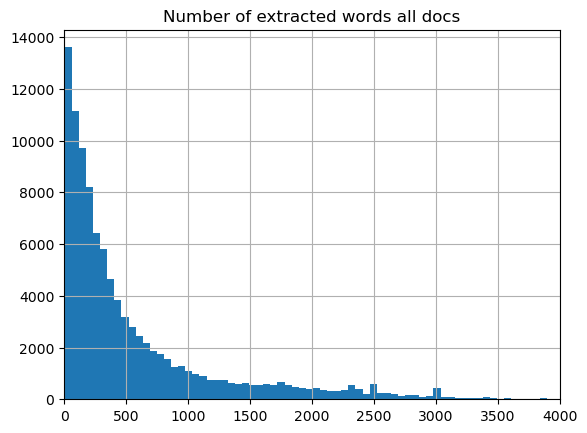

There are 30368 documents over 70793 with less then 5 words extracted for AC


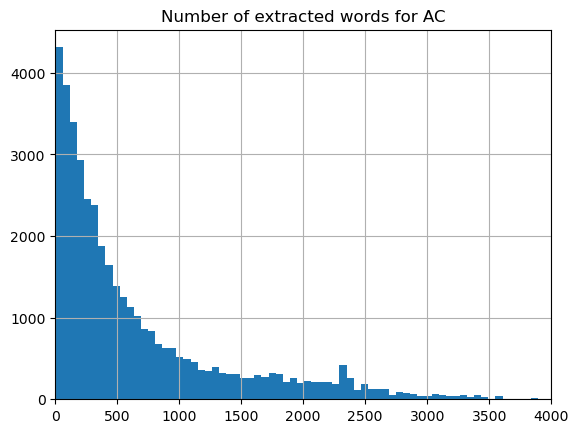

There are 0 documents over 0 with less then 5 words extracted for ORDER_8300.10


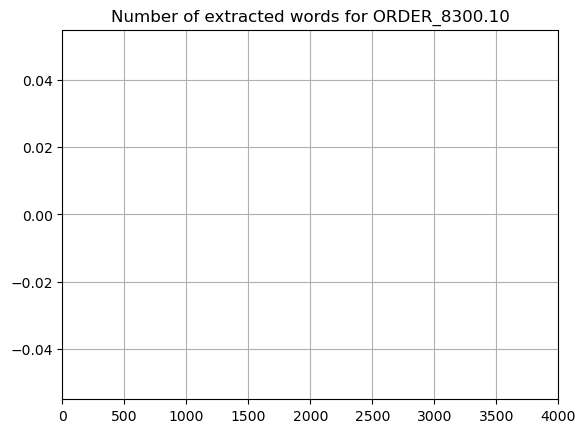

There are 0 documents over 0 with less then 5 words extracted for ORDER_8400.10


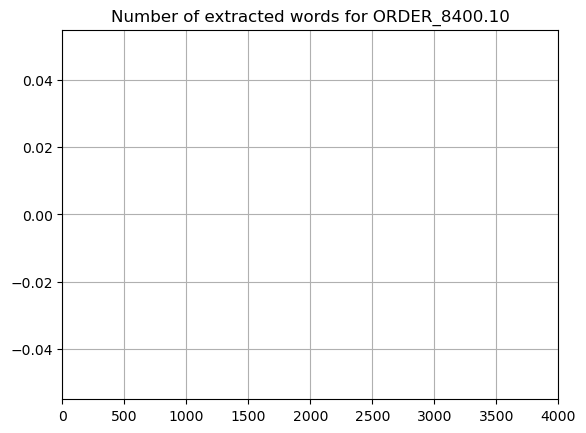

There are 0 documents over 0 with less then 5 words extracted for ORDER_8700.1


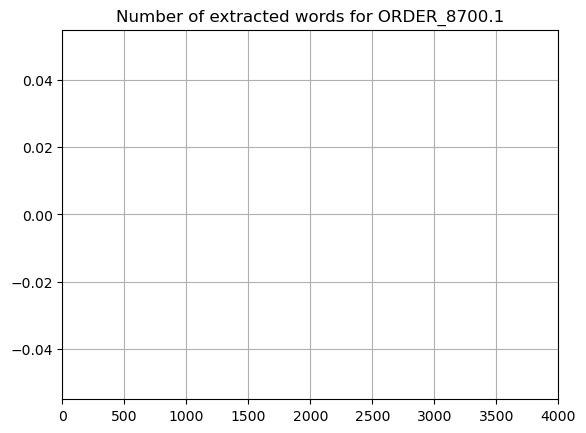

There are 0 documents over 0 with less then 5 words extracted for ORDER_8740.1


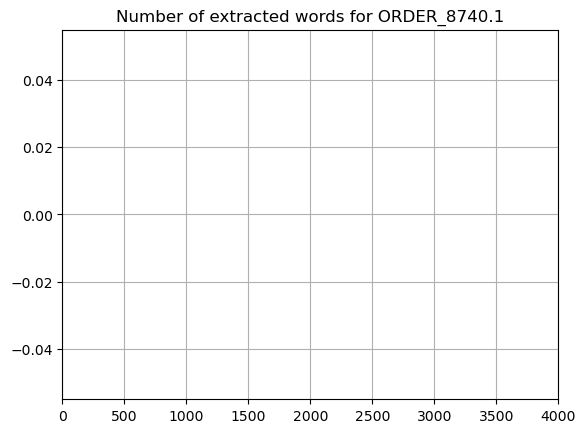

There are 20066 documents over 59036 with less then 5 words extracted for ORDER_8900.1


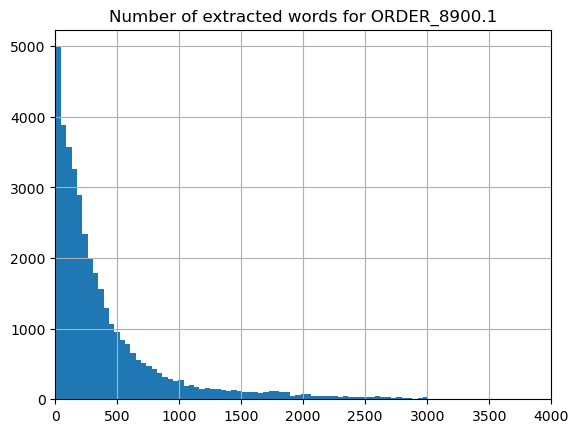

There are 12331 documents over 32779 with less then 5 words extracted for ORDERS


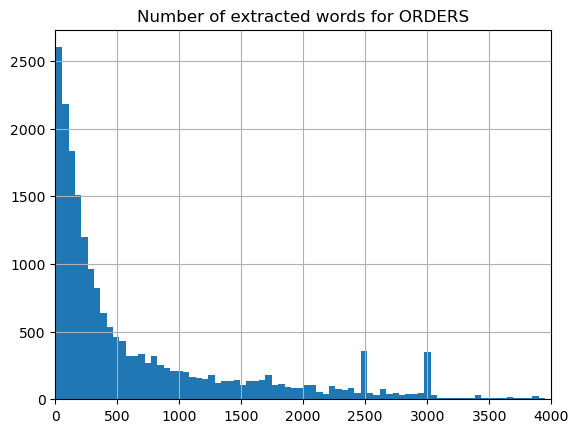

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = 6.4, 4.8

nb_words = 5

# All docs
df_nbwords = df_dataset['content'].apply(len)
nb_zerowords_docs = df_nbwords[df_nbwords<nb_words].shape[0]
print('There are %s documents over %s with less then %s words extracted for all docs' % (nb_zerowords_docs, df_nbwords.shape[0], nb_words))

df_nbwords = df_nbwords[df_nbwords>=nb_words]
df_nbwords.hist(bins=100) # .plot.bar() # plt.yticks(fontsize=10)
plt.xlim(left=0, right=4000)
plt.title("Number of extracted words all docs")
plt.show()

# By doc
for doc_type in doc_types:
    df_nbwords = df_dataset.loc[df_dataset[df_dataset['doc_type']==doc_type].index, 'content'].apply(len)
    nb_zerowords_docs = df_nbwords[df_nbwords<nb_words].shape[0]
    print('There are %s documents over %s with less then %s words extracted for %s' % (nb_zerowords_docs, df_nbwords.shape[0], nb_words, doc_type))

    df_nbwords = df_nbwords[df_nbwords>=nb_words]
    df_nbwords.hist(bins=100) # .plot.bar() # plt.yticks(fontsize=10)
    plt.xlim(left=0, right=4000)
    plt.title("Number of extracted words for "+doc_type)
    plt.show()

### Exploring some examples to find patterns

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

nb_words = 5
fields = ['content', 'parents_title_list', 'documentURL']
df_dataset_debug = df_dataset[fields]
df_dataset_debug['size content'] = df_dataset['content'].apply(len)
df_dataset_debug = df_dataset_debug.sort_values(by=['size content'])

C:\Users\victor\AppData\Local\Temp\ipykernel_12708\3165917587.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dataset_debug['size content'] = df_dataset['content'].apply(len)


### Try to find patterns in df_dataset for debugging/improviong the 92_split functions